<a href="https://colab.research.google.com/github/arnavdodiedo/RL-Algorithms/blob/main/A2C_CartPole_V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A2C on Cartpole-V0

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
!apt update && apt install xvfb
!pip install gym-notebook-wrapper

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/grap

In [45]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(ActorCritic, self).__init__()

        self.num_inputs = num_inputs
        self.num_actions = num_outputs

        self.actor_l1 = nn.Linear(self.num_inputs, 256)        
        self.actor_l2 = nn.Linear(256, self.num_actions)

        self.critic_l1 = nn.Linear(self.num_inputs, 256)        
        self.critic_l2 = nn.Linear(256, 1)
    
    def forward(self, state):
        state = Variable(state)

        x = F.relu(self.critic_l1(state))        
        value = self.critic_l2(x)

        x = F.relu(self.actor_l1(state))        
        prob_dist = F.softmax(self.actor_l2(x), dim=1)

        return value, prob_dist

class a2c():
    def __init__(self, input_dim, output_dim, lr = 1e-3):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.model = ActorCritic(input_dim, output_dim)
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.lr)
    
    def get_value_prob(self, state):
        value, prob = self.model(torch.from_numpy(state).float().unsqueeze(0))
        prob = prob.squeeze(0)  
        value = value.squeeze(0)
        return value, prob

In [59]:
env = gym.make("CartPole-v0")

gamma = 0.99
num_episodes = 1500

num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n

# model = ActorCritic(num_inputs, num_actions)
# adam = torch.optim.Adam(model.parameters(), lr=3e-4)

agent = a2c(num_inputs, num_actions, lr=3e-4)

actorloss_l, criticloss_l = [], []
all_rewards = []
entropy_term = 0

for episode in tqdm(range(num_episodes)):
    log_probs = []
    rewards = []
    values = []
    values1 = []
    done = False
    state = env.reset()

    while not done:
        value, prob_dist = agent.get_value_prob(state)
        # print(value.squeeze(0))
        value = value.detach().numpy()[0]
        # value = value1[0]
        # print("-=> ", value, value1)
        dist = prob_dist.detach().numpy()

        action = np.random.choice(num_actions, p = np.squeeze(dist))
        log_prob = torch.log(prob_dist.squeeze(0)[action])

        entropy = -np.sum(np.mean(dist)*np.log(dist))

        new_state, reward, done, _ = env.step(action)

        state = new_state
        log_probs.append(log_prob)
        values.append(value)
        # values1.append(value1)
        rewards.append(reward)
        entropy_term += entropy

        if done:
            qval, _ = agent.get_value_prob(new_state)
            qval = qval.detach().numpy()

            all_rewards.append(np.sum(rewards))            
        
    # print(values, values1)
    qvals = np.zeros_like(values)

    for t in reversed(range(len(rewards))):
        qval = rewards[t] + gamma*qval
        qvals[t] = qval

    values = torch.FloatTensor(np.asarray(values))
    # values1 = torch.FloatTensor(np.asarray(values1))
    qvals = torch.FloatTensor(qvals)

    log_probs = torch.stack(log_probs)

    advantage = qvals-values
    # print(advantage.shape, (qvals-values1).shape)
    # print(advantage, qvals-values1)

    actorloss = (-log_probs*advantage).mean()
    criticloss = 0.5 * advantage.pow(2).mean()
    loss = actorloss + criticloss + 0.001*entropy_term

    actorloss_l.append(actorloss)
    criticloss_l.append(criticloss)

    agent.optim.zero_grad()
    loss.backward()
    agent.optim.step()


100%|██████████| 1500/1500 [00:50<00:00, 29.43it/s]


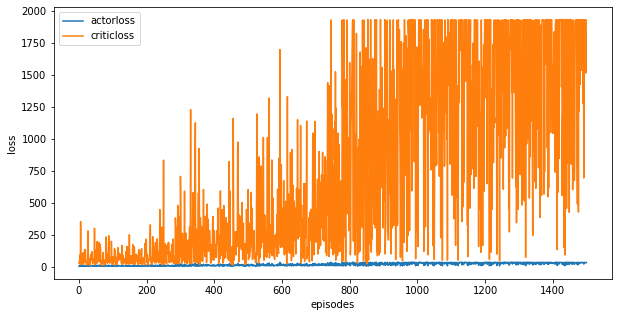

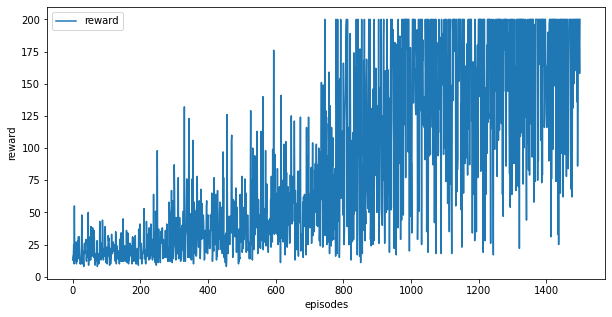

In [60]:
plt.figure(figsize=(10,5))
plt.plot(actorloss_l)
plt.plot(criticloss_l)
plt.xlabel("episodes")
plt.ylabel("loss")
plt.legend(["actorloss", "criticloss"])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(all_rewards)
plt.xlabel("episodes")
plt.ylabel("reward")
plt.legend(["reward"])
plt.show()

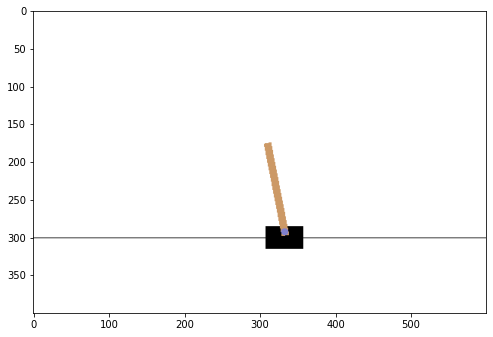

In [63]:
import matplotlib.animation as animation
import gnwrapper
from PIL import ImageFont, ImageDraw, Image
import numpy as np

agent.model.eval()

env = gnwrapper.LoopAnimation(gym.make('CartPole-v0'))
state = env.reset()

rewards = []
for step in range(500):
    # env.render()
    env.render(mode='rgb_array')    
    
    value, prob_dist = agent.get_value_prob(state)    
    dist = prob_dist.detach().numpy()
    action = np.random.choice(num_actions, p = np.squeeze(dist))
    
    state, reward, done, _ = env.step(action)    
    rewards.append(reward)

    if done: break

env.display()


In [64]:
sum(rewards)

200.0

## Tester module

In [39]:
a = np.asarray([1,2,3,4,5])
b = np.asarray([[2],[3],[4],[5],[6]])
a-b

array([[-1,  0,  1,  2,  3],
       [-2, -1,  0,  1,  2],
       [-3, -2, -1,  0,  1],
       [-4, -3, -2, -1,  0],
       [-5, -4, -3, -2, -1]])

In [44]:
a = np.asarray([1,2,3])
print(a.shape)
b = np.asarray([[1,1,1],[2,2,2],[1,1,1]])
print(b.shape)
np.matmul(a,b)

(3,)
(3, 3)


array([8, 8, 8])

In [57]:
a = np.asarray([1,2,3])
print(a.shape)
b = np.asarray([[4],[5],[6]])
print(b.shape)
a*b

(3,)
(3, 1)


array([[ 4,  8, 12],
       [ 5, 10, 15],
       [ 6, 12, 18]])

In [58]:
a = np.asarray([[1],[2],[3]])
print(a.shape)
b = np.asarray([4,5,6])
print(b.shape)
a*b

(3, 1)
(3,)


array([[ 4,  5,  6],
       [ 8, 10, 12],
       [12, 15, 18]])